In [7]:
import datetime
import os

import lightning as l
import torch as th
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.strategies import DDPStrategy
from torch.utils.data import DataLoader, random_split

from callbacks import EMACallback
from data_utils.dataset import Lee2019Dataset
from framework import SDEFramework

from configs.Lee2019_ERP_CFG import (
    DATASET_CFG,
    FRAMEWORK_CFG,
    MODEL_CFG,
    RUN_CFG,
    SAMPLING_CFG,
    SDE_CFG,
)

/nvme1/xiejy/projects/Conditional-EEG-Diffusion-main/data_utils/dataset.py:138: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_LEE2019_ERP_PATH"
  mne.set_config(f"MNE_DATASETS_{self.dataset.upper()}_PATH", self.path)


Trying to load data for subjects: [1, 2, 3, 4, 5, 6, 7, 8]
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding meta

/nvme1/xiejy/envs/Diffusion/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


Adding metadata with 3 columns
66240 matching events found
No baseline correction applied
Replacing existing metadata with 4 columns


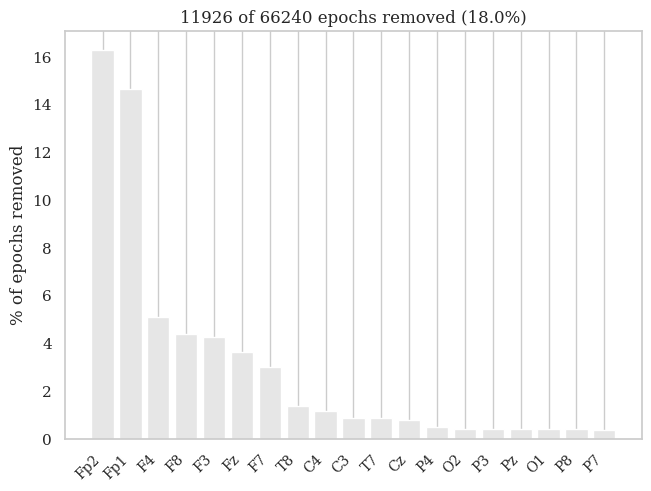

In [2]:
dataset = Lee2019Dataset(**DATASET_CFG)

In [4]:
checkpoint_dir = os.path.join(RUN_CFG["project_name"], RUN_CFG["run_name"]).replace(
    "\\", "/"
)

In [8]:
from configs.Lee2019_ERP_CFG import (
    DATASET_CFG,
    FRAMEWORK_CFG,
    MODEL_CFG,
    RUN_CFG,
    SAMPLING_CFG,
    SDE_CFG,
)

if isinstance(DATASET_CFG["user_conditions"], list):
    MODEL_CFG["model__conditionals_combinations"] = dataset.condition_combinations

In [10]:
framework = SDEFramework(
    **RUN_CFG,
    **FRAMEWORK_CFG,
    **MODEL_CFG,
    **SDE_CFG,
    **SAMPLING_CFG,
    **DATASET_CFG,
)

In [11]:
framework

SDEFramework(
  (model): EEGWave(
    (x_conv): Sequential(
      (0): Conv2d(1, 128, kernel_size=(19, 1), stride=(1, 1))
      (1): ReLU()
    )
    (step_embedding): DiffusionStepEmbedding(
      (step_embedding_linear): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): SiLU()
      )
    )
    (embedding_layers): ModuleList(
      (0): Sequential(
        (0): Embedding(8, 128)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): SiLU()
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): SiLU()
      )
      (1-2): 2 x Sequential(
        (0): Embedding(2, 128)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): SiLU()
        (3): Linear(in_features=512, out_features=512, bias=True)
        (4): SiLU()
      )
    )
    (res_layers_list): ModuleList(
      (0): EEGWaveResidualLa

In [12]:
train_dataset, val_dataset = random_split(
    dataset,
    [1 - RUN_CFG["val_split"], RUN_CFG["val_split"]],
    th.Generator().manual_seed(42),
)

In [14]:
callbacks = [
    ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="{step}-{validation_loss:.3f}",
        every_n_train_steps=RUN_CFG["checkpoint_freq"],
        save_top_k=-1,
    ),
    EMACallback(),
]

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=RUN_CFG["batch_size"], shuffle=False, drop_last=False
)
val_dataloader = DataLoader(
    val_dataset, batch_size=RUN_CFG["batch_size"], shuffle=False, drop_last=False
)

In [16]:
trainer = l.Trainer(
    log_every_n_steps=1,
    callbacks=callbacks,
    gradient_clip_val=RUN_CFG["gradient_clip_val"],
    max_steps=RUN_CFG["steps"],
    strategy=DDPStrategy(timeout=datetime.timedelta(minutes=300)),
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


MisconfigurationException: `Trainer(strategy=<lightning.pytorch.strategies.ddp.DDPStrategy object at 0x7f208486e150>)` is not compatible with an interactive environment. Run your code as a script, or choose a notebook-compatible strategy: `Trainer(strategy='ddp_notebook')`. In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

In [ ]:
# train the model
trainer.fit(framework, train_dataloader, val_dataloader)